In [2]:
import itertools
from IPython.display import Image
from IPython import display
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

In [3]:
batch_sizes = 50

train_data = datasets.MNIST('./data/', download=True, train=True, transform= transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
    ]))
train_loader = torch.utils.data.DataLoader(train_data, batch_size = batch_sizes, shuffle=True)

val_data = datasets.MNIST('./data/', download=True, train=True, transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
    ]))
val_loader = torch.utils.data.DataLoader(val_data, batch_size = batch_sizes, shuffle=True)

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw
Processing...



Done!


/pytorch/torch/csrc/utils/tensor_numpy.cpp:141: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program.


In [4]:
num_batches = len(train_loader)

In [5]:
data = next(iter(train_loader))

In [6]:
img, label = data

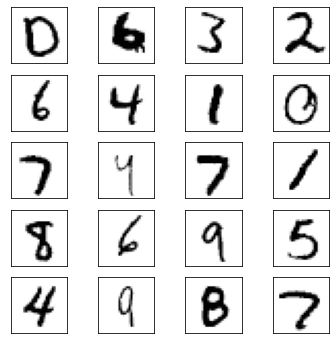

In [7]:
# create figure for plotting
row_num = 5
col_num = 4
fig, ax = plt.subplots(row_num, col_num, figsize=(6,6))
for i, j in itertools.product(range(row_num), range(col_num)):
    ax[i,j].get_xaxis().set_visible(False)
    ax[i,j].get_yaxis().set_visible(False)
    
    
for k in range(row_num*col_num):
    i = k//col_num
    j = k%col_num
    ax[i,j].cla() # clear the current axis
    ax[i,j].imshow(img[k,:].data.cpu().numpy().reshape(28,28), cmap='Greys')

In [8]:
# CNN model image
Image(url= "https://9bow.github.io/PyTorch-tutorials-kr/_images/mnist.png")

In [17]:
# construct model on cuda if available

use_cuda = torch.cuda.is_available()

class CNNClassifier(nn.Module):
    
    def __init__(self):
        # 항상 torch.nn.Module을 상속받고 시작
        super(CNNClassifier, self).__init__()
        conv1 = nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5, stride=1) # 6@24*24
        # activation ReLU
        pool1 = nn.MaxPool2d(2) # 6@12*12
        conv2 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5, stride=1) # 16@8*8
        # activation ReLU
        pool2 = nn.MaxPool2d(2) # 16@4*4
        
        self.conv_module = nn.Sequential(
            conv1,
            nn.ReLU(),
            pool1,
            conv2,
            nn.ReLU(),
            pool2
        )
        
        fc1 = nn.Linear(16*4*4, 120)
        # activation ReLU
        fc2 = nn.Linear(120, 84)
        # activation ReLU
        fc3 = nn.Linear(84, 10)

        self.fc_module = nn.Sequential(
            fc1,
            nn.ReLU(),
            fc2,
            nn.ReLU(),
            fc3
        )
        
        # gpu로 할당
        if use_cuda:
            self.conv_module = self.conv_module.cuda()
            self.fc_module = self.fc_module.cuda()
        
    def forward(self, x):
        out = self.conv_module(x) # @16*4*4
        # make linear
        dim = 1
        for d in out.size()[1:]: #16, 4, 4
            dim = dim * d
        out = out.view(-1, dim)
        out = self.fc_module(out)
        return out

In [18]:
cnn = CNNClassifier()

In [31]:
# loss
criterion = nn.CrossEntropyLoss()
# backpropagation method
learning_rate = 1e-3
optimizer = optim.Adam(cnn.parameters(), lr=learning_rate)

In [32]:
# hyper-parameters
num_epochs = 2

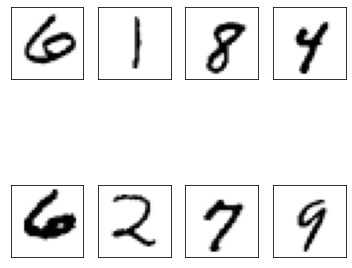

label: tensor([6, 1, 8, 4, 6, 2, 7, 9], device='cuda:0')
prediction: tensor([6, 1, 8, 4, 6, 2, 7, 9], device='cuda:0')
epoch: 2/2 | step: 1200/1200 | train loss: 0.0270 | val loss: 0.0184


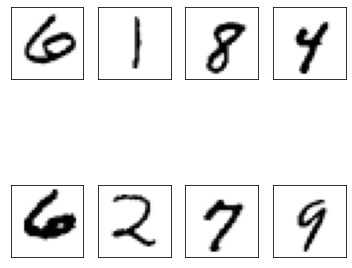

In [33]:
# create figure for plotting
row_num = 2
col_num = 4
fig, ax = plt.subplots(row_num, col_num, figsize=(6,6))
for i, j in itertools.product(range(row_num), range(col_num)):
    ax[i,j].get_xaxis().set_visible(False)
    ax[i,j].get_yaxis().set_visible(False) 
    
train_loss_list = []
val_loss_list = []

for epoch in range(num_epochs):
    train_loss = 0.0
    for i, data in enumerate(train_loader):
        x, label = data
        if use_cuda:
            x = x.cuda()
            label = label.cuda()
        # grad init
        optimizer.zero_grad()
        # forward propagation
        model_output = cnn(x)
        # calculate loss
        loss = criterion(model_output, label)
        # back propagation 
        loss.backward()
        # weight update
        optimizer.step()
        
        # train_loss summary
        train_loss += loss.item()
        # del (memory issue)
        del loss
        del model_output
        
        # 학습과정 출력
        if (i+1) % 100 == 0: # every 100 mini-batches
            with torch.no_grad(): # very very very very important!!!
                val_loss = 0.0
                for j, val in enumerate(val_loader):
                    val_x, val_label = val
                    if use_cuda:
                        val_x = val_x.cuda()
                        val_label =val_label.cuda()
                    val_output = cnn(val_x)
                    v_loss = criterion(val_output, val_label)
                    val_loss += v_loss

            # draw last val dataset
            for k in range(row_num*col_num):
                ii = k//col_num
                jj = k%col_num
                ax[ii,jj].cla() # clear the current axis
                ax[ii,jj].imshow(val_x[k,:].data.cpu().numpy().reshape(28,28), cmap='Greys')
            
            display.clear_output(wait=True)
            display.display(plt.gcf()) # get a reference to a current figure
                
            print("label: {}".format(val_label[:row_num*col_num]))
            print("prediction: {}".format(val_output.argmax(dim=1)[:row_num*col_num]))
            del val_output
            del v_loss
            
            print("epoch: {}/{} | step: {}/{} | train loss: {:.4f} | val loss: {:.4f}".format(
                epoch+1, num_epochs, i+1, num_batches, train_loss / 100, val_loss / len(val_loader)
            ))            
            
            train_loss_list.append(train_loss/100)
            val_loss_list.append(val_loss/len(val_loader))
            train_loss = 0.0

Text(0, 0.5, 'loss')

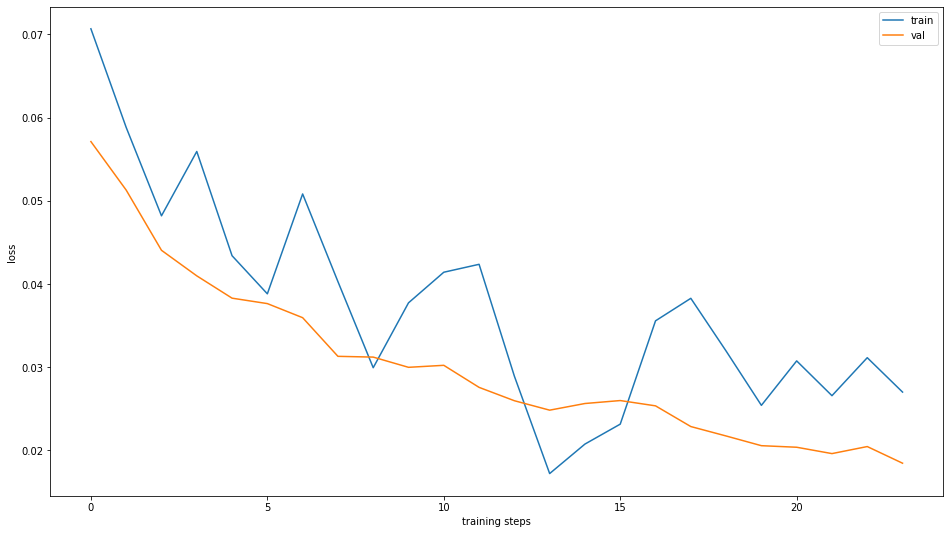

In [34]:
plt.figure(figsize=(16,9))
x_range = range(len(train_loss_list))
plt.plot(x_range, train_loss_list, label="train")
plt.plot(x_range, val_loss_list, label="val")
plt.legend()
plt.xlabel("training steps")
plt.ylabel("loss")

In [35]:
# val acc
with torch.no_grad():
    corr_num = 0
    total_num = 0
    for j, val in enumerate(val_loader):
        val_x, val_label = val
        if use_cuda:
            val_x = val_x.cuda()
            val_label =val_label.cuda()
        val_output = cnn(val_x)
        model_label = val_output.argmax(dim=1)
        corr = val_label[val_label == model_label].size(0)
        corr_num += corr
        total_num += val_label.size(0)

print("acc: {:.2f}".format(corr_num / total_num * 100))

acc: 99.44
